# Project 6 - Nematode status assay

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import filters, segmentation, feature, measure
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
from scipy import signal
from PIL import Image
from collections import Counter

/home/lilian/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Correct loading

[[ 94  93  94 ...  94  92  95]
 [ 93  93  94 ...  97  95  90]
 [ 93  93  98 ...  95  94  98]
 ...
 [ 94  99 100 ...  99  99 100]
 [ 96  94  98 ...  94 100  96]
 [ 97  94 101 ... 100  97  98]] 3026


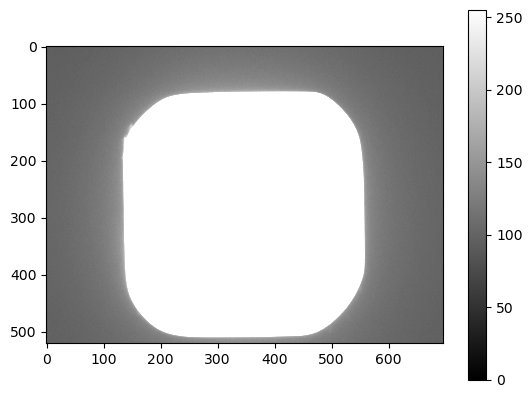

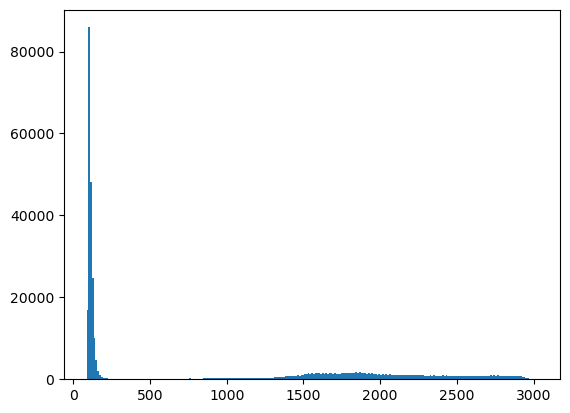

In [3]:
test = Image.open('Data/1649_1109_0003_Amp5-1_B_20070424_A01_w2_15ADF48D-C09E-47DE-B763-5BC479534681.tif')
test_pixels = np.asarray(test)
print(test_pixels, np.max(test_pixels))
plt.imshow(test_pixels, cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()
plt.hist(test_pixels.flatten(), bins = 255)
plt.show()

In [4]:
def stretch(img):
    mini = np.min(img)
    maxi = np.max(img)
    return (255*((img-mini)/(maxi-mini)))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 1 0]
 [0 0 1 ... 1 0 0]]


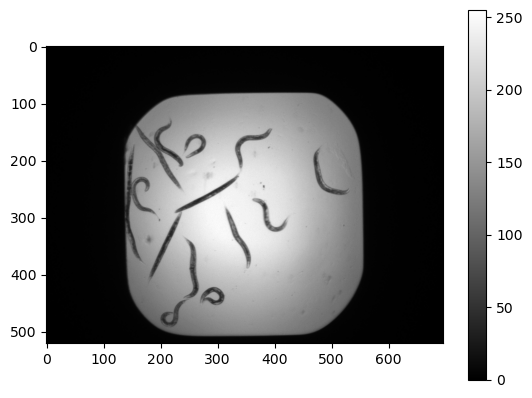

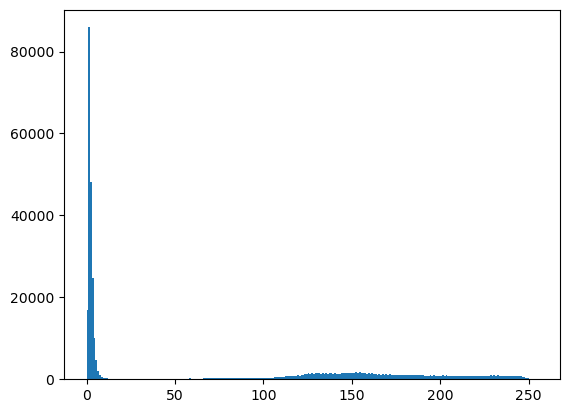

In [5]:
stretch_test_pixel = stretch(test_pixels).astype(int)
print(stretch_test_pixel)

plt.imshow(stretch_test_pixel, cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()
plt.hist(stretch_test_pixel.flatten(), bins = 255)
plt.show()

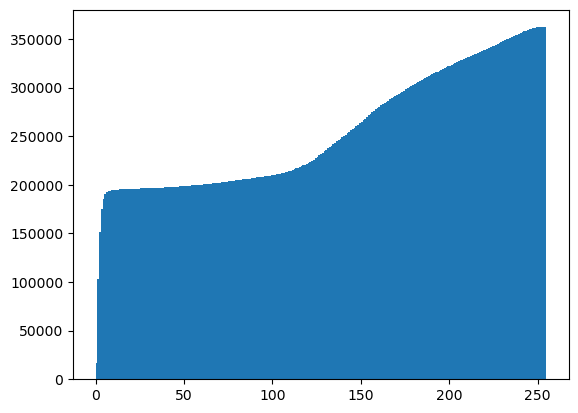

In [6]:
plt.hist(stretch_test_pixel.flatten(), bins = 255, cumulative='T')
plt.show()

# Quality verification

# Segmentation

## Window extraction

In [7]:
window_threshold = 8

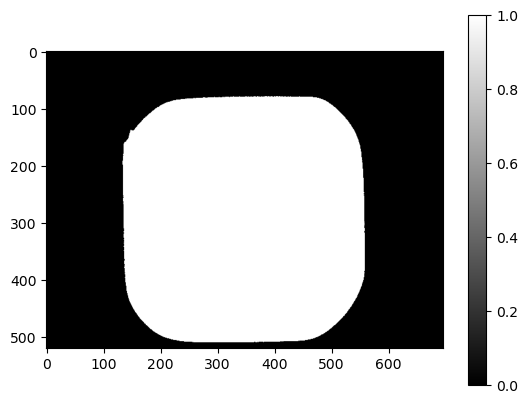

In [8]:
empty_window = stretch_test_pixel>window_threshold
plt.imshow(empty_window, cmap="gray", vmin = 0, vmax = 1)
plt.colorbar()
plt.show()

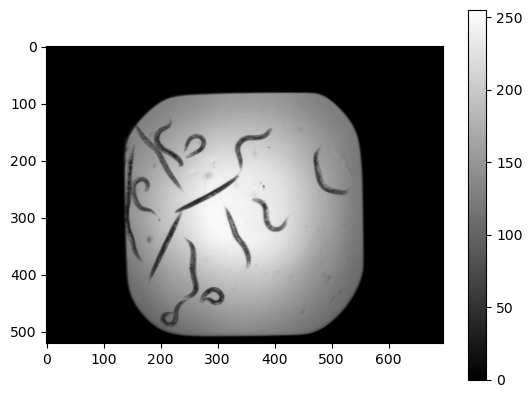

In [9]:
window = empty_window*stretch_test_pixel
plt.imshow(window, cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()

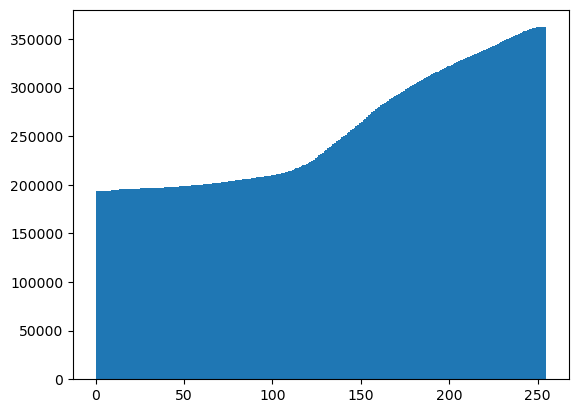

In [10]:
plt.hist(window.flatten(), bins = 255, cumulative='T')
plt.show()

## Do a uniformisation of the luminosity of the window ?

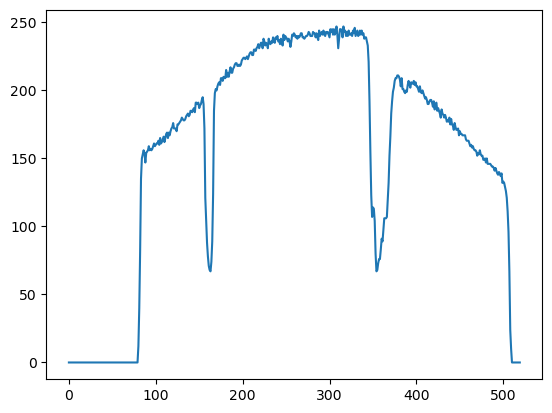

In [11]:
plt.plot(window[:,350])
plt.show()

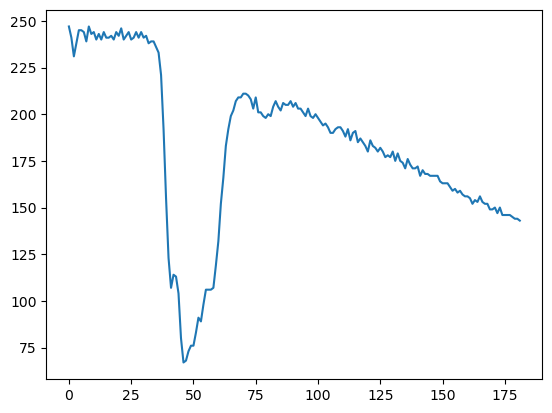

In [12]:
line = window[:,350][np.argmax(window[:,350]):490]
plt.plot(line)
plt.show()

In [13]:
print(np.max(line))
print(np.min(line))
print(len(line))

247
67
182


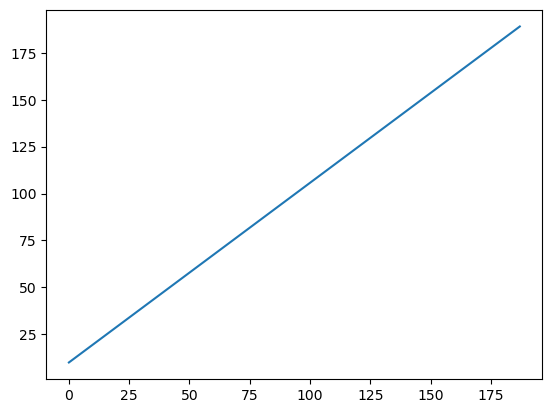

In [14]:
def lum(line,d):
    return 10 + d*(max(line)-min(line))/188

plt.plot(lum(line,np.arange(188)))
plt.show()

In [15]:
n,p = empty_window.shape
barycenter_i = 0
barycenter_j = 0
for i in range(n):
    for j in range(p):
        barycenter_i += empty_window[i,j]*i
        barycenter_j += empty_window[i,j]*j
barycenter_i /= np.sum(empty_window)
barycenter_j /= np.sum(empty_window)
window_center = (int(barycenter_i),int(barycenter_j))
window_center

(293, 345)

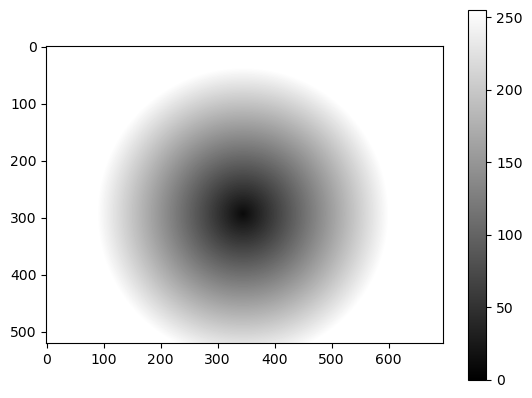

In [16]:
negative_vignetage = np.zeros((n,p))
for i in range(n):
    for j in range(p):
        d = np.sqrt((window_center[0]-i)**2 + (window_center[1]-j)**2)
        negative_vignetage[i,j] = lum(line,d)

plt.imshow(negative_vignetage, cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()

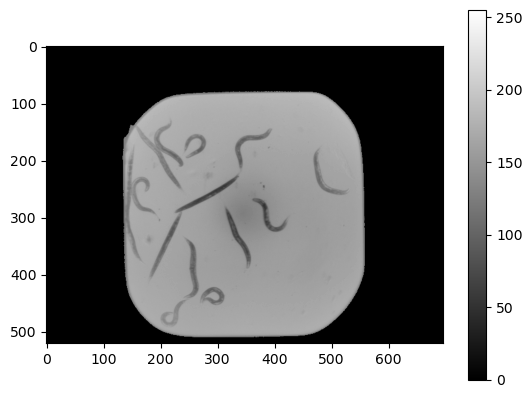

In [17]:
unif_window = (empty_window*(window + negative_vignetage)/2).astype(int)
plt.imshow(unif_window, cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()

## Contour detection

sobel is good because of the brigth countours of nematods ?

### All the contours

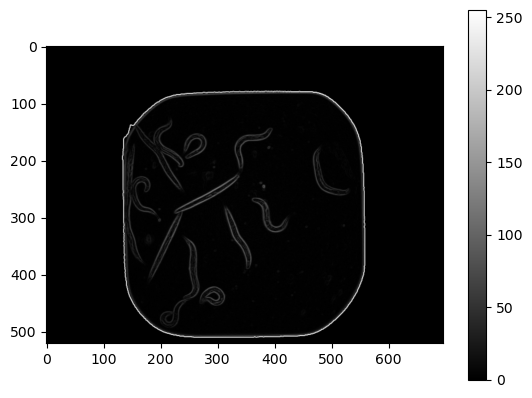

In [18]:
all_contours = stretch(filters.sobel(unif_window))
plt.imshow(all_contours, cmap="gray")
plt.colorbar()
plt.show()

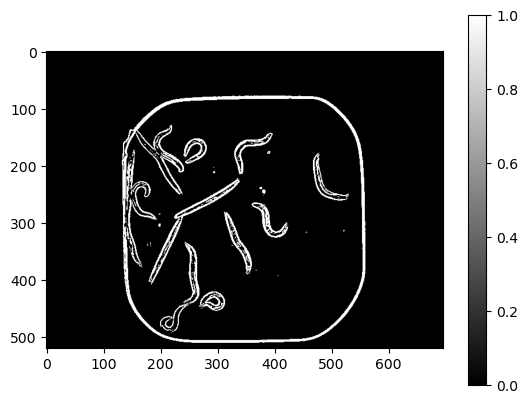

In [19]:
plt.imshow(all_contours>20, cmap="gray")
plt.colorbar()
plt.show()

### Window contours

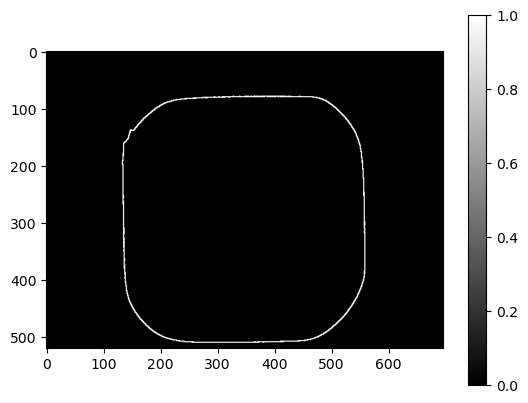

In [20]:
negative_window_contour = stretch(filters.sobel(empty_window))>30
plt.imshow(negative_window_contour, cmap="gray")
plt.colorbar()
plt.show()

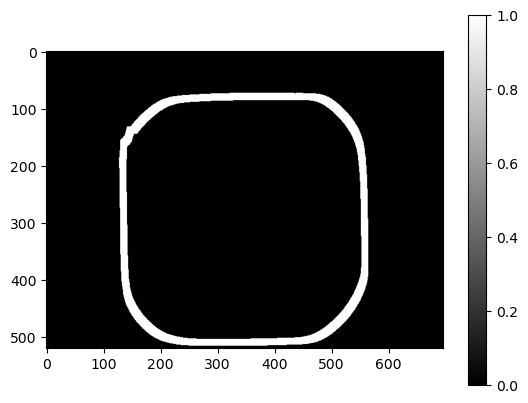

In [21]:
width = 11
wide_negative_window_contour = signal.convolve2d(negative_window_contour,np.ones((width,width)),mode='same')>0
plt.imshow(wide_negative_window_contour, cmap="gray")
plt.colorbar()
plt.show()

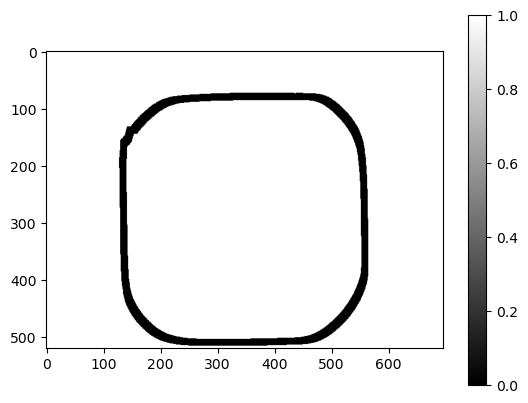

In [22]:
plt.imshow(~wide_negative_window_contour, cmap="gray")
plt.colorbar()
plt.show()

### Nematods contours

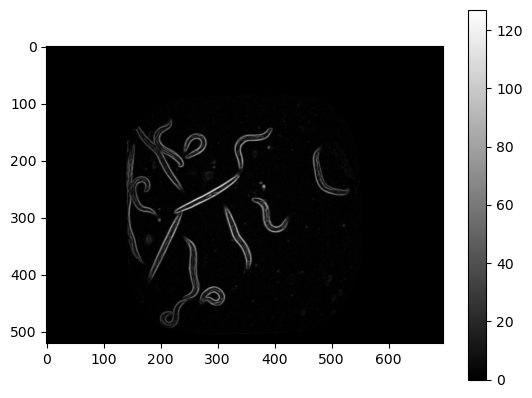

In [23]:
inside_contours = np.multiply(~wide_negative_window_contour,all_contours).astype(int)
plt.imshow(inside_contours, cmap="gray")
plt.colorbar()
plt.show()

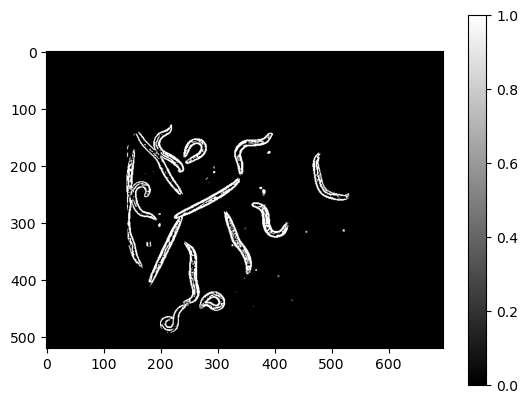

In [24]:
plt.imshow(inside_contours>15, cmap="gray")
plt.colorbar()
plt.show()

# Morphological operations
 closing could work

In [25]:
def erosion(bin_img,structuring_element = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype(int)):
    n,p = bin_img.shape
    ero_img = bin_img.copy()
    a,_ = structuring_element.shape
    if a%2==0:
        return "impossible"
    for i in range(a,n-a):
        for j in range(a,p-a):
            extract_img = bin_img[i-a//2:i+a//2+1,j-a//2:j+a//2+1]
            if np.sum(structuring_element * extract_img) < np.sum(structuring_element) :
                ero_img[i,j] = 0
            else :
                ero_img[i,j] = 1
    return ero_img


In [26]:
def dilatation(bin_img,structuring_element = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype(int)):
    n,p = bin_img.shape
    ero_img = bin_img.copy()
    a,_ = structuring_element.shape
    if a%2==0:
        return "impossible"
    for i in range(a,n-a):
        for j in range(a,p-a):
            extract_img = bin_img[i-a//2:i+a//2+1,j-a//2:j+a//2+1]
            if np.sum(structuring_element * extract_img) > 0 :
                ero_img[i,j] = 1
            else :
                ero_img[i,j] = 0
    return ero_img


In [27]:
def multiple_erosions_and_dilataions(bin_img,l):
    for letter in l:
        if letter=='e':
            bin_img = erosion(bin_img).copy()
        elif letter=='d':
            bin_img = dilatation(bin_img).copy()
    return bin_img

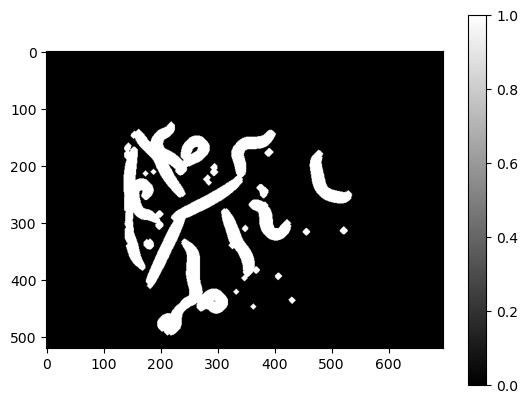

In [28]:
close_nematods = multiple_erosions_and_dilataions(inside_contours>15,5*['d'])
plt.imshow(close_nematods, cmap="gray")
plt.colorbar()
plt.show()

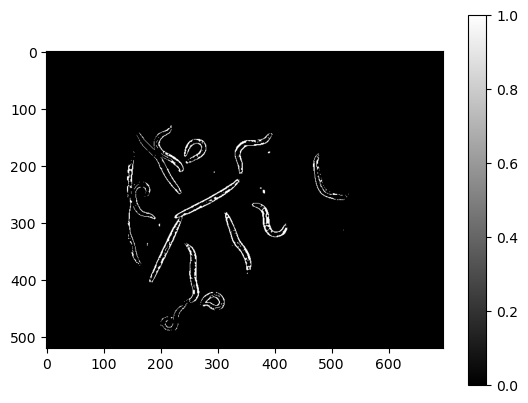

In [29]:
close_nematods = multiple_erosions_and_dilataions(inside_contours>15,['e'])
plt.imshow(close_nematods, cmap="gray")
plt.colorbar()
plt.show()

## Segmentation

Watershed good because of overlaps ?

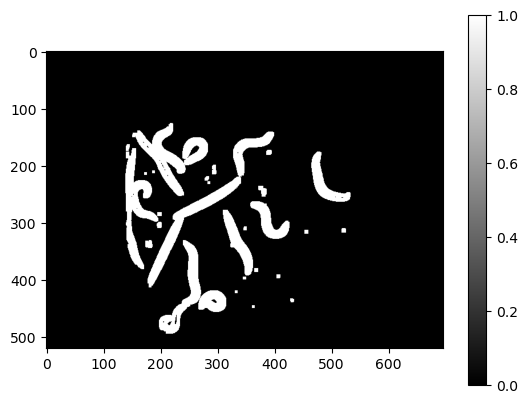

In [30]:
width = 5
nematods = signal.convolve2d((inside_contours>15),np.ones((width,width)),mode='same')>0
plt.imshow(nematods, cmap="gray")
plt.colorbar()
plt.show()

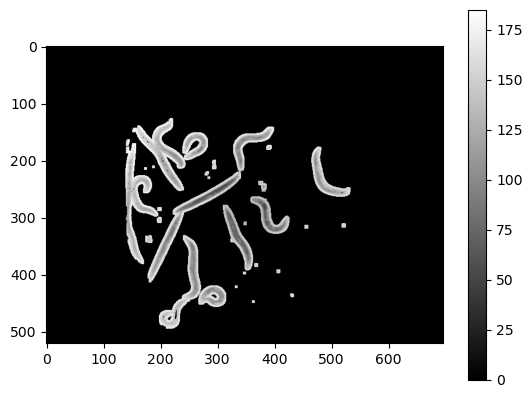

In [31]:
window_segmented = nematods*unif_window
plt.imshow(window_segmented, cmap="gray")
plt.colorbar()
plt.show()

# Tests

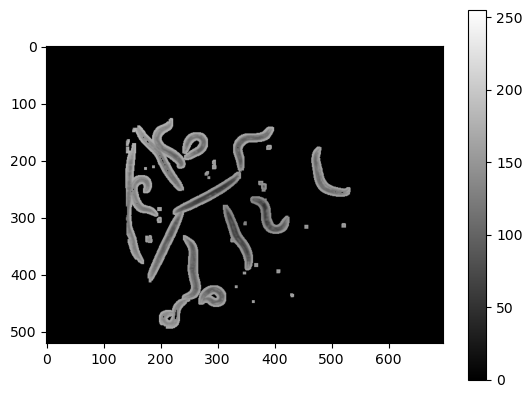

In [32]:
plt.imshow(window_segmented, cmap="gray", vmin = 0, vmax = 255)
plt.colorbar()
plt.show()

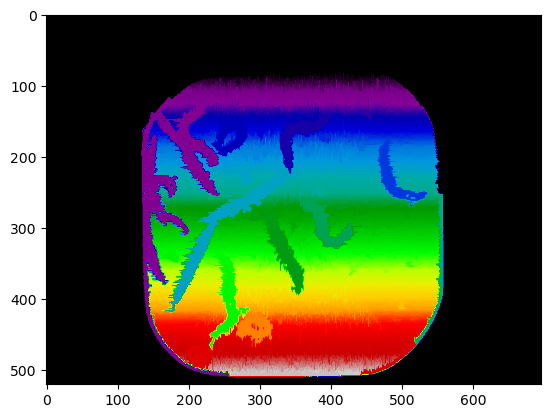

In [33]:
distance30 = ndi.distance_transform_edt(unif_window)
coords30 = feature.peak_local_max(distance30, footprint=np.ones((3,3)), labels=unif_window)

mask30 = np.zeros(distance30.shape, dtype=bool)
mask30[tuple(coords30.T)] = True
markers30, _ = ndi.label(mask30)
chev30_watershed = segmentation.watershed(-distance30, markers30, mask=unif_window)
plt.imshow(chev30_watershed, cmap="nipy_spectral")
plt.show()

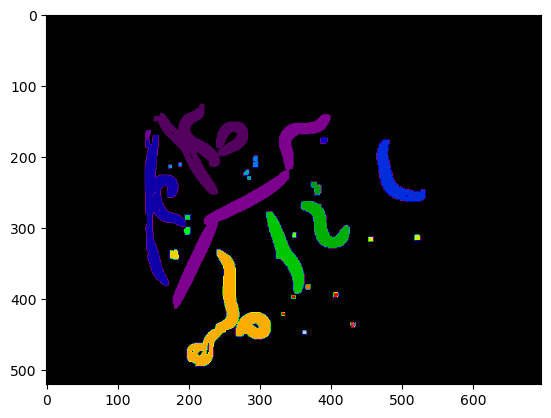

In [34]:
distance30 = ndi.distance_transform_edt(window_segmented)
coords30 = feature.peak_local_max(distance30, footprint=np.ones((1,1)), labels=window_segmented)

mask30 = np.zeros(distance30.shape, dtype=bool)
mask30[tuple(coords30.T)] = True
markers30, _ = ndi.label(mask30)
chev30_watershed = segmentation.watershed(-distance30, markers30, mask=window_segmented)
plt.imshow(chev30_watershed, cmap="nipy_spectral")
plt.show()

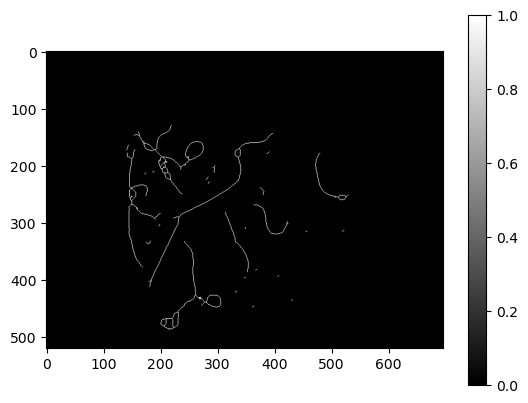

In [35]:
from skimage.morphology import skeletonize

skeleton = skeletonize(nematods)
plt.imshow(skeleton, cmap="gray")
plt.colorbar()
plt.show()

# Extraction de descripteurs

In [36]:
def labeling(image):
    binary_image = (image > 0).astype(int)
    labeled = np.zeros_like(binary_image, dtype=int)
    
    label =0 
    equivalences = {}
    
    rows, cols = binary_image.shape
    for r in range(rows):
        for c in range(cols):
            if binary_image[r,c] == 0:
                continue
            
            voisins = []
            for dr in [-1, 0]:
                for dc in [-1, 0, 1]:
                    if dr == 0 and dc == 0:
                        continue
                    rr, cc = r + dr, c + dc
                    if 0 <= rr < rows and 0 <= cc < cols:
                        if labeled[rr, cc] > 0:
                            voisins.append(labeled[rr, cc])
            if not voisins:
                label += 1
                labeled[r, c] = label
                equivalences[label] = {label}
            else:
                def most_common(lst):
                    return max(set(lst), key=lst.count)
                most_common_label = most_common(voisins)
                labeled[r, c] = most_common_label
              
                for n in voisins:
                    equivalences[most_common_label].add(n)
                    equivalences.setdefault(n, set()).add(most_common_label)
        
    label_map = {}
    for k, eq in equivalences.items():
        root = min(eq)
        for e in eq:
            label_map[e] = root

    for r in range(rows):
        for c in range(cols):
            if labeled[r, c] > 0:
                labeled[r, c] = label_map[labeled[r, c]]

    return labeled


In [37]:
labeled_nematods = labeling(distance30)

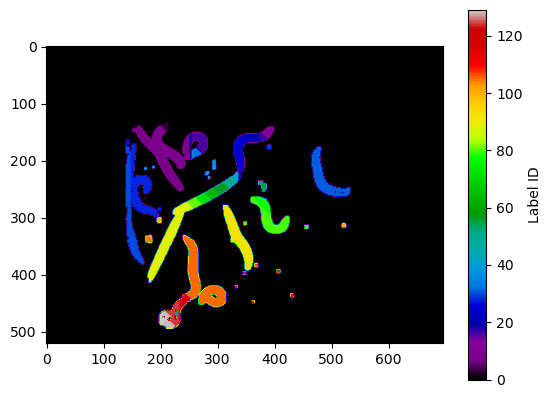

In [38]:
plt.imshow(labeled_nematods, cmap="nipy_spectral")

plt.colorbar(label='Label ID')
plt.show()